<h1 style="text-align: center">Glass-Bangle-detection Using Resnet and GoogleNet</h1>

<h3 style="text-align:right">-By Aryan Gupta</h3>

In [1]:
%pip install split_folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/














In [3]:
%pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


















































In [4]:
import opendatasets as od
import pandas

od.download(
	"https://www.kaggle.com/datasets/almique/glass-bangle-defect-detection-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds



Your Kaggle username: aryagup



Your Kaggle Key: ··········





100%|██████████| 1.31G/1.31G [00:08<00:00, 158MB/s]


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import splitfolders
import matplotlib.pyplot as plt

In [6]:
input_folder = "/content/glass-bangle-defect-detection-classification/dataset/"
output = "/content/split-dataset1" #where you want the split datasets saved. one will be created if it does not exist or none is set

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.8, .2)) # ratio of split are in order of train/val/test. You can change to whatever you want. For train/val sets only, you could do .75, .25 for example.

Copying files: 1080 files [00:05, 209.24 files/s]


# Data-Preprocessing and Normalisation

In [9]:

mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data_dir = '/content/split-dataset1'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=0) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(class_names)

['broken', 'defect', 'good']


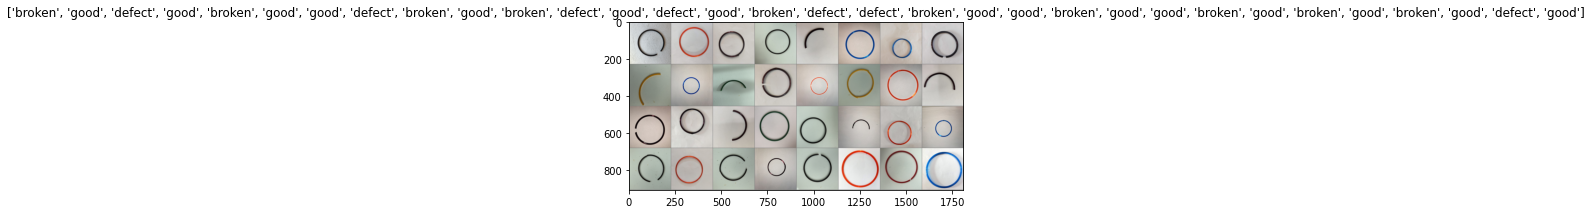

In [10]:

def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [11]:
device

device(type='cuda')

In [31]:
train_error_list = []
train_accuracy_list = []
val_error_list = []
val_accuracy_list = []
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            if phase == 'train':
                train_error_list.append(epoch_loss)
                train_accuracy_list.append(epoch_acc)
            if phase == 'val':
                val_error_list.append(epoch_loss)
                val_accuracy_list.append(epoch_acc)
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Resnet

In [13]:
#### Finetuning the convnet ####
# Load a pretrained model and reset final fully connected layer.

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 3)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=6)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.



  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "



/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.



  warnings.warn(msg)



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch 0/5



----------



train Loss: 0.9580 Acc: 0.5504



val Loss: 0.7653 Acc: 0.7281







Epoch 1/5



----------



train Loss: 0.7195 Acc: 0.7439



val Loss: 0.6078 Acc: 0.8065







Epoch 2/5



----------



train Loss: 0.5812 Acc: 0.8239



val Loss: 0.5340 Acc: 0.8479







Epoch 3/5



----------



train Loss: 0.5127 Acc: 0.8343



val Loss: 0.4566 Acc: 0.8802







Epoch 4/5



----------



train Loss: 0.4569 Acc: 0.8575



val Loss: 0.4212 Acc: 0.8986







Epoch 5/5



----------



train Loss: 0.4184 Acc: 0.8621



val Loss: 0.3902 Acc: 0.8848







Training complete in 19m 31s



Best val Acc: 0.898618


In [ ]:
train_accuracy_list = [(x.cpu().numpy()) for x in train_accuracy_list]

In [28]:
val_accuracy_list = [(x.cpu().numpy()) for x in val_accuracy_list]

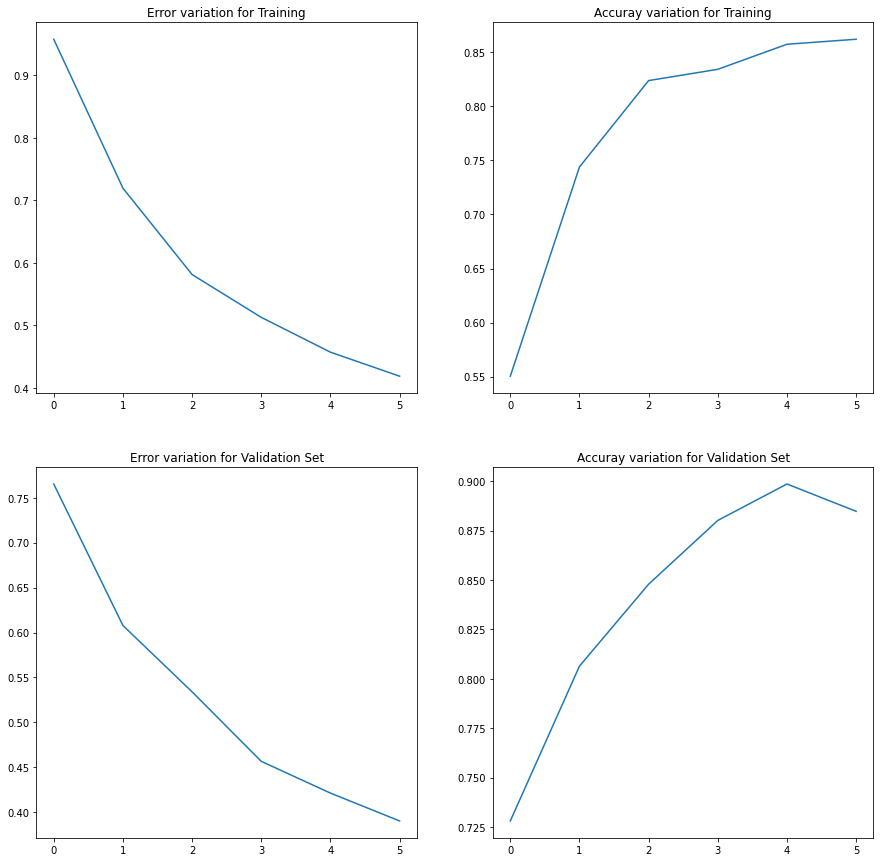

In [29]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2, figsize=(15, 15))
  
# For train error
axis[0, 0].plot([x for x in range(len(train_error_list))], train_error_list)
axis[0, 0].set_title("Error variation for Training")
# For train accuracy
axis[0, 1].plot([x for x in range(len(train_accuracy_list))], train_accuracy_list)
axis[0, 1].set_title("Accuray variation for Training")
# For validation error
axis[1, 0].plot([x for x in range(len(val_error_list))], val_error_list)
axis[1, 0].set_title("Error variation for Validation Set")
# For validation accuracy
axis[1, 1].plot([x for x in range(len(val_accuracy_list))], val_accuracy_list)
axis[1, 1].set_title("Accuray variation for Validation Set")
plt.show()

## GoogleNet

In [34]:
#### Finetuning the convnet ####
# Load a pretrained model and reset final fully connected layer.

model = models.googlenet(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 3)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=6)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.



  warnings.warn(msg)



Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

Epoch 0/5



----------



train Loss: 0.9866 Acc: 0.5643



val Loss: 0.9518 Acc: 0.5622







Epoch 1/5



----------



train Loss: 0.9255 Acc: 0.5921



val Loss: 0.8891 Acc: 0.6498







Epoch 2/5



----------



train Loss: 0.8624 Acc: 0.6744



val Loss: 0.8322 Acc: 0.6866







Epoch 3/5



----------



train Loss: 0.8147 Acc: 0.7068



val Loss: 0.7855 Acc: 0.7189







Epoch 4/5



----------



train Loss: 0.7732 Acc: 0.7207



val Loss: 0.7501 Acc: 0.7051







Epoch 5/5



----------



train Loss: 0.7269 Acc: 0.7462



val Loss: 0.7118 Acc: 0.7788







Training complete in 19m 42s



Best val Acc: 0.778802


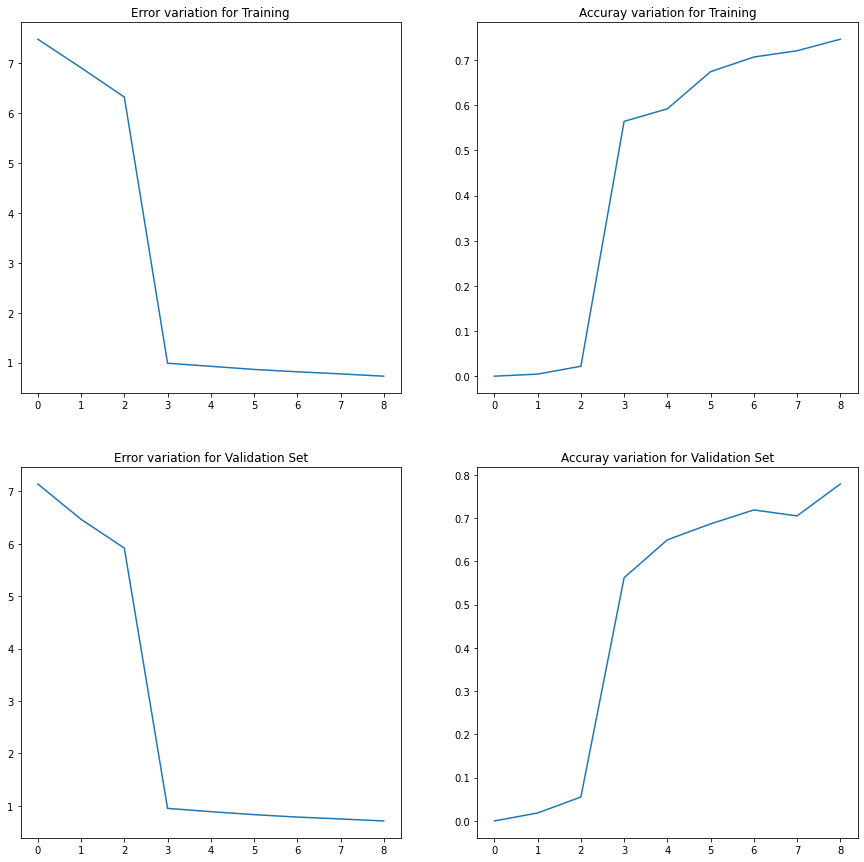

In [35]:
train_accuracy_list = [(x.cpu().numpy()) for x in train_accuracy_list]
val_accuracy_list = [(x.cpu().numpy()) for x in val_accuracy_list]
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2, figsize=(15, 15))
  
# For training loss
axis[0, 0].plot([x for x in range(len(train_error_list))], train_error_list)
axis[0, 0].set_title("Error variation for Training")

# For training accuracy  
axis[0, 1].plot([x for x in range(len(train_accuracy_list))], train_accuracy_list)
axis[0, 1].set_title("Accuray variation for Training")

# For validation loss
axis[1, 0].plot([x for x in range(len(val_error_list))], val_error_list)
axis[1, 0].set_title("Error variation for Validation Set")
  
# For validation accuracy
axis[1, 1].plot([x for x in range(len(val_accuracy_list))], val_accuracy_list)
axis[1, 1].set_title("Accuray variation for Validation Set")
# Combine all the operations and display
plt.show()

## CNN Keras

<h3 style="text-align:right">-By Arihant Bhandari</h3>

In [1]:
# importing modules

import numpy as np
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import (InputLayer, Conv2D, MaxPooling2D, MaxPool2D, Flatten, 
                          Dense, BatchNormalization, Dropout, ELU, UpSampling2D)
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Nadam
from keras.layers import Input, Multiply, UpSampling2D
from keras.models import Model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

2024-05-27 17:11:46.642957: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 17:11:46.643085: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 17:11:46.766879: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def plot_history(history):
    # store results
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # plot results
    # accuracy
    plt.figure(figsize=(5, 8))
    plt.rcParams['figure.figsize'] = [8, 4]
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.grid'] = True
    plt.rcParams['figure.facecolor'] = 'white'
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(round(acc[-1],3))}\nValidation Accuracy: {str(round(val_acc[-1],3))}')
    
    print()

    # loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title(f'Training and Validation Loss. \nTrain Loss: {str(round(loss[-1],3))}\nValidation Loss: {str(round(val_loss[-1],3))}')
    plt.xlabel('epoch')
    plt.tight_layout(pad=3.0)
    plt.show()

In [3]:
# Load the dataset
dataset = keras.utils.image_dataset_from_directory(
    "/kaggle/input/glass-bangle-defect-detection-classification/dataset",
    image_size=(400, 400),
    batch_size=32
)

# Normalize the dataset
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_dataset = dataset.map(lambda x, y: (normalization_layer(x), y))

# Convert images to grayscale and invert colors
def process_images(images, labels):
    # Convert to grayscale
    gray_images = tf.image.rgb_to_grayscale(images)
    # Invert colors
    inverted_images = 1.0 - gray_images
    return inverted_images, labels

processed_dataset = normalized_dataset.map(process_images)

# Prepare the dataset for training
images_list = []
labels_list = []

for images, labels in processed_dataset:
    for image, label in zip(images, labels):
        image_array = image.numpy()
        images_list.append(image_array)
        labels_list.append(label.numpy())

images_array = np.asarray(images_list)
labels_array = np.asarray(labels_list)

# One-hot encode the labels
predictor_labels = np.eye(3)[labels_array]

# Split the data
x_train, x_temp, y_train, y_temp = train_test_split(images_array, predictor_labels, test_size=0.3,random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5,random_state=42)

print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)
print("x_val:", x_val.shape)
print("y_val:", y_val.shape)

Found 1080 files belonging to 3 classes.
x_train: (756, 400, 400, 1)
y_train: (756, 3)
x_test: (162, 400, 400, 1)
y_test: (162, 3)
x_val: (162, 400, 400, 1)
y_val: (162, 3)


In [4]:
model = Sequential() # sequential model
model.add(InputLayer(shape=(224,224, 1)))
model.add(Conv2D(filters=64, kernel_size=2, activation='relu', padding="same")) # convolution block with downsampling and batch normalization
model.add(MaxPool2D())
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=2, activation='relu', padding="same")) # convolution block with downsampling and batch normalization
model.add(MaxPool2D())
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=2, activation='relu', padding="same")) # convolution block with downsampling and batch normalization
model.add(MaxPool2D())
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=2, activation='relu', padding="same")) # convolution block with downsampling and batch normalization
model.add(MaxPool2D())
model.add(BatchNormalization())

model.add(Dropout(rate=0.25))

model.add(Flatten())

model.add(Dense(128, activation='relu')) # dense layer
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))
model.add(Dense(3, activation='softmax'))

# callbacks: model checkpoint and reducing lr on plateau for focusing model towards problem
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00000001, verbose=1)

model.compile(optimizer=Nadam(learning_rate=0.1), loss='categorical_crossentropy', metrics=['accuracy']) # compiling model layers

model.summary() # model summary

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,657,347 (6.32 MB)

 Trainable params: 1,656,579 (6.32 MB)

 Non-trainable params: 768 (3.00 KB)

In [5]:
# Training model
history = model.fit(x_train,y_train,batch_size=80,epochs=150,verbose=1,validation_data=(x_val,y_val),callbacks=[model_checkpoint, reduce_lr])

Epoch 1/150

 1/10 ━━━━━━━━━━━━━━━━━━━━ 3:30 23s/step - accuracy: 0.2875 - loss: 2.0384


I0000 00:00:1716789316.298020     122 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

W0000 00:00:1716789316.321478     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4098 - loss: 2.2438   

W0000 00:00:1716789328.877988     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update

W0000 00:00:1716789329.900895     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update




Epoch 1: val_accuracy improved from -inf to 0.21605, saving model to model.keras

10/10 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.4150 - loss: 2.2157 - val_accuracy: 0.2160 - val_loss: 2489.4988 - learning_rate: 0.1000

Epoch 2/150


W0000 00:00:1716789331.073461     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.5920 - loss: 1.1159

Epoch 2: val_accuracy did not improve from 0.21605

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.5926 - loss: 1.1112 - val_accuracy: 0.2160 - val_loss: 1061.4594 - learning_rate: 0.1000

Epoch 3/150

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.6553 - loss: 0.9152

Epoch 3: val_accuracy did not improve from 0.21605

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.6557 - loss: 0.9156 - val_accuracy: 0.2160 - val_loss: 308.3292 - learning_rate: 0.1000

Epoch 4/150

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.6799 - loss: 0.7575

Epoch 4: val_accuracy did not improve from 0.21605

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.6807 - loss: 0.7566 - val_accuracy: 0.2160 - val_loss: 71.5488 - learning_rate: 0.1000

Epoch 5/150

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.6830 - loss: 0.7988

Epoch 5: val_accuracy did not improve from 0.21605

10/10 ━━━━━━━━━━━

In [6]:
# loading best model and testing

model1 = keras.models.load_model('model.keras', custom_objects={"ELU": keras.layers.ELU,"PReLU": keras.layers.PReLU}) # loading saved model

y_test_categorical = np.argmax(y_test, axis=1) # turning y_test probability distributions back to labels

y_pred_prob_val = model1.predict(x_test) # predicting

y_pred_val = np.argmax(y_pred_prob_val, axis=1) # turning y_pred probability distributions back to labels

# Accuracy
accuracy = accuracy_score(y_test_categorical, y_pred_val)
print("Accuracy:", accuracy)

# Precision
precision = precision_score(y_test_categorical, y_pred_val, average='macro')
print("Precision:", precision)

# Recall
recall = recall_score(y_test_categorical, y_pred_val, average='macro')
print("Recall:", recall)

# F1 Score
f1 = f1_score(y_test_categorical, y_pred_val, average='macro')
print("F1 Score:", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_categorical, y_pred_val)
print("Confusion Matrix:")
print(conf_matrix)

1/6 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step

W0000 00:00:1716789542.505883     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step

Accuracy: 0.8148148148148148

Precision: 0.8084067536295051

Recall: 0.7887957990213629

F1 Score: 0.7965163842984425

Confusion Matrix:

[[38  4  7]

 [ 4 26  8]

 [ 1  6 68]]


W0000 00:00:1716789543.050263     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [7]:
model1.evaluate(x_test,y_test) # evaluating model

5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8094 - loss: 0.4860 

W0000 00:00:1716789544.144380     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.8109 - loss: 0.4904


W0000 00:00:1716789544.531498     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[0.5013639330863953, 0.8148148059844971]

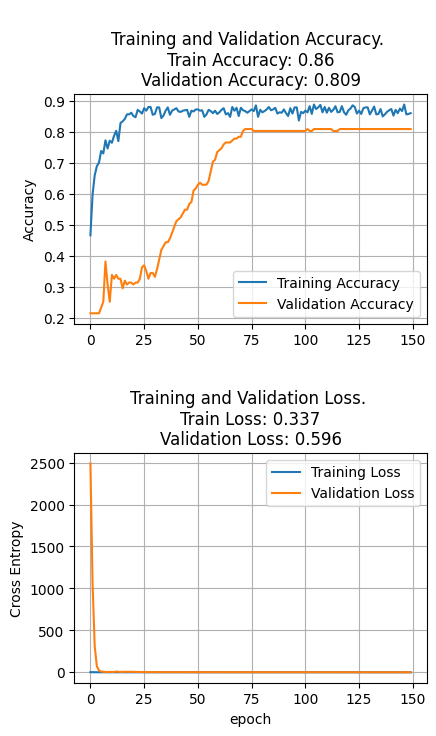

In [8]:
plot_history(history) # plotting model history

## CNN with Attention Keras

In [45]:
from keras.layers import Input, GlobalAveragePooling2D, Multiply, UpSampling2D
from keras.models import Model

def simple_attention(inputs):

    attention = Conv2D(1, 1, activation='softmax')(inputs)
    
    attention = Multiply()([inputs, attention])
    
    return attention

# Input layer
inputs = Input(shape=(400, 400, 1), name='input_layer')

# Layer 1
layer1 = Conv2D(filters=64, kernel_size=3, activation=ELU(), padding="same")(inputs)
layer1 = BatchNormalization()(layer1)
layer1 = MaxPool2D()(layer1)

# Layer 2
layer2 = Conv2D(filters=64, kernel_size=3, activation=ELU(), padding="same")(layer1)
layer2 = BatchNormalization()(layer2)
layer2 = MaxPool2D()(layer2)

# Layer 3
layer3 = Conv2D(filters=128, kernel_size=3, activation=ELU(), padding="same")(layer2)
layer3 = BatchNormalization()(layer3)
layer3 = MaxPool2D()(layer3)

layer3 = Conv2D(filters=128, kernel_size=3, activation=ELU(), padding="same",kernel_initializer='he_uniform')(layer3)
layer3 = BatchNormalization()(layer3)
layer3 = MaxPool2D()(layer3)

layer3 = Conv2D(filters=256, kernel_size=3, activation=ELU(), padding="same",kernel_initializer='he_uniform')(layer3)
layer3 = BatchNormalization()(layer3)
layer3 = MaxPool2D()(layer3)

layer3 = Conv2D(filters=256, kernel_size=3, activation=ELU(), padding="same",kernel_initializer='he_uniform')(layer3)
layer3 = BatchNormalization()(layer3)
layer3 = MaxPool2D()(layer3)

attention_layer = simple_attention(layer3)

drop = Dropout(rate=0.2)(attention_layer)

# Flatten and dense layers
flattened = Flatten()(attention_layer)
dense1 = Dense(512, activation=ELU())(flattened)
dense1 = BatchNormalization()(dense1)
dense1 = Dense(128, activation=ELU())(dense1)
dense1 = BatchNormalization()(dense1)
dense1 = Dense(64, activation=ELU())(dense1)
dense1 = BatchNormalization()(dense1)
dense1 = Dense(32, activation='relu')(dense1)
dense1 = BatchNormalization()(dense1)

outputs = Dense(3, activation='softmax')(dense1)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

model_checkpoint = ModelCheckpoint('att_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(mode='min', monitor='val_loss', factor=0.5, patience=5, min_lr=0.00000001, verbose=1)

model.compile(optimizer=Nadam(learning_rate=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 400, 400,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 400, 400,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 400,  │        256 │ conv2d_63[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_54    │ (None, 200, 200,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 200, 200,  │     36,928 │ max_pooling2d_54… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 200,  │        256 │ conv2d_64[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_55    │ (None, 100, 100,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 100, 100,  │     73,856 │ max_pooling2d_55… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 100,  │        512 │ conv2d_65[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_56    │ (None, 50, 50,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 50, 50,    │    147,584 │ max_pooling2d_56… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        512 │ conv2d_66[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_57    │ (None, 25, 25,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_67 (Conv2D)  │ (None, 25, 25,    │    295,168 │ max_pooling2d_57… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 25,    │      1,024 │ conv2d_67[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_58    │ (None, 12, 12,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_68 (Conv2D)  │ (None, 12, 12,    │    590,080 │ max_pooling2d_58

 Total params: 5,946,244 (22.68 MB)

 Trainable params: 5,942,980 (22.67 MB)

 Non-trainable params: 3,264 (12.75 KB)

In [46]:
# Training model
history = model.fit(x_train,y_train,batch_size=40,epochs=50,verbose=1,validation_data=(x_val,y_val),callbacks=[model_checkpoint, reduce_lr])

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 6, 6, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
W0000 00:00:1716836467.273753     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.4928 - loss: 1.3603

W0000 00:00:1716836477.425910     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.4978 - loss: 1.3417

W0000 00:00:1716836479.028931     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.25926, saving model to att_model.keras


W0000 00:00:1716836479.946326     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 708ms/step - accuracy: 0.5023 - loss: 1.3249 - val_accuracy: 0.2593 - val_loss: 134537.6719 - learning_rate: 0.1000
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.7207 - loss: 0.6450
Epoch 2: val_accuracy did not improve from 0.25926
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 380ms/step - accuracy: 0.7209 - loss: 0.6450 - val_accuracy: 0.2593 - val_loss: 5061.1211 - learning_rate: 0.1000
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.7564 - loss: 0.6076
Epoch 3: val_accuracy did not improve from 0.25926
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 388ms/step - accuracy: 0.7568 - loss: 0.6058 - val_accuracy: 0.2593 - val_loss: 1103.0677 - learning_rate: 0.1000
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.7697 - loss: 0.5335
Epoch 4: val_accuracy improved from 0.25926 to 0.27160, saving model to att_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 416ms/step - accuracy: 0.7700 - loss: 0.5329 - val_accuracy: 0.2716 - val_loss: 272.797

In [50]:
# testing model 

model2 = keras.models.load_model('att_model.keras', custom_objects={"ELU": keras.layers.ELU,"PReLU": keras.layers.PReLU}) # loading saved model

y_test_categorical = np.argmax(y_test, axis=1) # turning y_test probability distributions back to labels

y_pred_prob_val = model2.predict(x_test) # predicting

y_pred_val = np.argmax(y_pred_prob_val, axis=1) # turning y_pred probability distributions back to labels

# Accuracy
accuracy = accuracy_score(y_test_categorical, y_pred_val)
print("Accuracy:", accuracy)

# Precision
precision = precision_score(y_test_categorical, y_pred_val, average='macro')
print("Precision:", precision)

# Recall
recall = recall_score(y_test_categorical, y_pred_val, average='macro')
print("Recall:", recall)

# F1 Score
f1 = f1_score(y_test_categorical, y_pred_val, average='macro')
print("F1 Score:", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_categorical, y_pred_val)
print("Confusion Matrix:")
print(conf_matrix)

/opt/conda/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 6, 6, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


3/6 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step

W0000 00:00:1716837392.474688     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step
Accuracy: 0.8827160493827161
Precision: 0.8660337552742616
Recall: 0.8528709389597439
F1 Score: 0.8583142639206712
Confusion Matrix:
[[55  1  4]
 [ 0 21  8]
 [ 0  6 67]]


W0000 00:00:1716837393.613711     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [51]:
model2.evaluate(x_test,y_test) # evaluating model

/opt/conda/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 6, 6, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2/6 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8906 - loss: 0.3982

W0000 00:00:1716837395.194726     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy: 0.8892 - loss: 0.3958


W0000 00:00:1716837396.154656     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[0.4420726001262665, 0.8827160596847534]

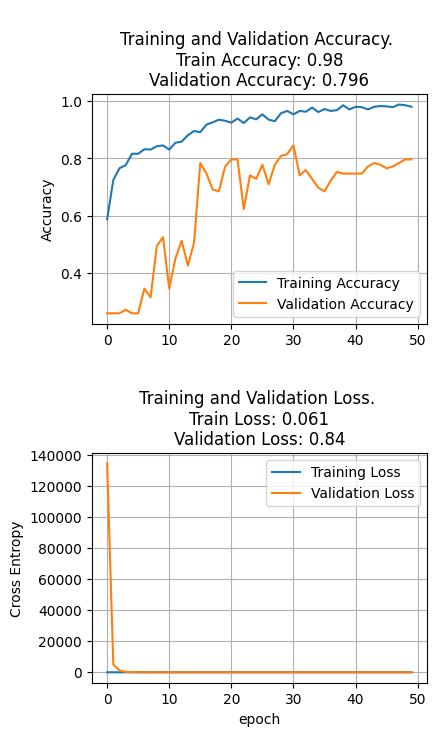

In [52]:
plot_history(history) # plotting history